In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable  # CHECK: do I need this?

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from scipy.stats import norm

import time


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Simulate data

In [3]:
input_size = 2   # input is theta and z_i
output_size = 2  # output is mu_i and log(sigma_i) 
nn_width = 15

class likelihood_NN(nn.Module):
    
    def __init__(self):
        super(likelihood_NN, self).__init__()
        
    def forward_mean(self, theta, z):
        m = theta[:, None] + torch.sin(z) * z + z
        return m
    
    def forward_sd(self, theta, z):
        s = torch.cos(z)
        return s
    

In [4]:
torch.manual_seed(1789)  # use a fixed seed for simulation data
likelihood_nn = likelihood_NN().to(device)

theta = torch.randn(1)

n = 10000
theta_rep = theta.repeat(n)
z = 5 * torch.randn(n)
x = torch.randn(n, 1)

f_mean = likelihood_nn.forward_mean(theta, z)
f_sd = likelihood_nn.forward_sd(theta, z)

x = f_mean.reshape(n, 1) + x * torch.exp(f_sd).reshape(n, 1)


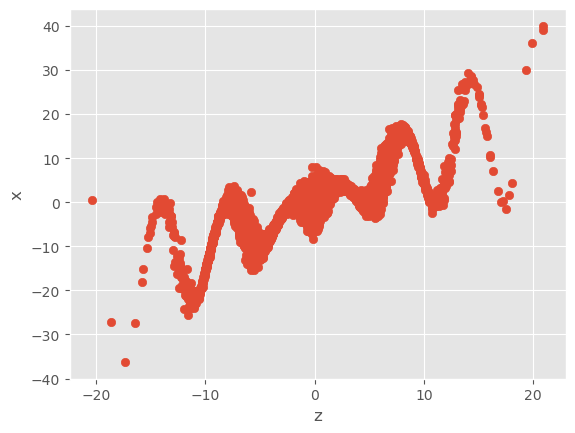

In [5]:
# Let's examine the data, in particular, plot x as a function of z.
plt.scatter(z.detach().numpy(), x.detach().numpy())
plt.xlabel("z")
plt.ylabel("x")
plt.savefig("to_discuss/z_deep.pdf")
plt.show()


/tmp/ipykernel_441620/3367864121.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


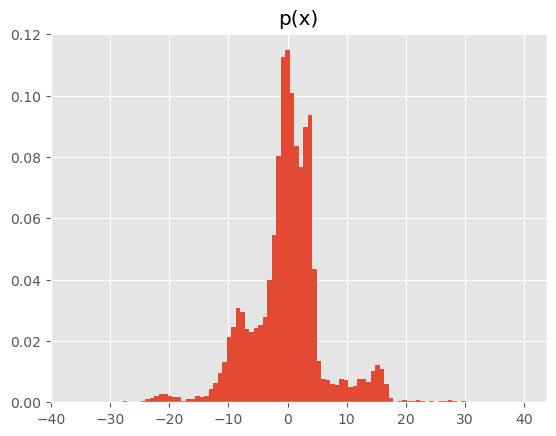

In [6]:
# plot x
nbins = 100
fig, axs = plt.subplots(1, 1)
axs.hist(x.numpy(), bins = nbins, density = True)
axs.set_title("p(x)")
fig.savefig("to_discuss/p_deep.pdf")
fig.show()

### Distributions for ELBO
Can use the same distributions for factorized and amortized VI. For amorizted VI, the arguments `nu_mean_z` and `nu_sd_z` will be the output of the inference network. Note that the joint $p(x, \theta, z)$ uses the known likelihood network.

In [7]:
# vanilla implementation (not vectorized)
def log_joint(x, theta, z):
    f_mean = likelihood_nn.forward_mean(theta, z).reshape(n, 1)
    f_sd = likelihood_nn.forward_sd(theta, z).reshape(n, 1)
        
    return -0.5 * torch.sum(z**2) - torch.sum(torch.div((x - f_mean)**2,
                                              2 * torch.exp(f_sd)**2))

def log_q(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2)\
                          * (z - nu_mean_z)**2)
    return log_q_theta + log_q_z
    

In [8]:
# vectorized version for GPU
def log_joint_v(x, theta, z):
    f_mean = likelihood_nn.forward_mean(theta, z)
    f_sd = likelihood_nn.forward_sd(theta, z)

    return -0.5 * torch.sum(z**2, dim = 1)\
        - torch.sum(torch.div((x - f_mean)**2, 2 * torch.exp(f_sd)**2), dim = 1)


def log_q_v(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2)\
                          * (z - nu_mean_z)**2, dim = 1)
    return log_q_theta + log_q_z


In [9]:
# TEST: check that the vectorized and non-vectorized log densities return the same output.
if(False):
    theta = theta.to(device)
    z = z.to(device)
    nu_mean_theta = torch.randn(1).to(device)
    nu_sd_theta = torch.exp(torch.randn(1, 1)).to(device)
    nu_mean_z = torch.randn((n, 1)).to(device)
    nu_sd_z = torch.exp(torch.randn((n, 1))).to(device)

    print(log_joint(x, theta, z))
    print(log_joint_v(x.reshape(n, 1), theta.reshape((1, 1)), z.reshape(1, n, 1)))


    log_q_evaluated = log_q(theta, z.reshape(n, 1), nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z)

    log_q_v_evaluated = log_q_v(theta, z.reshape(1, n, 1), nu_mean_theta,
                                nu_sd_theta, nu_mean_z, nu_sd_z)

    print(log_q_evaluated)
    print(log_q_v_evaluated)

    print(log_q_evaluated.shape)
    print(log_q_v_evaluated.shape)


### Model class for amortized VI

In [10]:
# Architecture for the inference network (for now stick to three layers.)
inf_input_size = 1  # inference network only takes in x_i

class MCElbo_AVI(torch.nn.Module):
    def __init__(self, inf_nn_width):
        super(MCElbo_AVI, self).__init__()

        # variational parameters for q(theta) # ToDO: set initial value
        self.nu_mean_theta = torch.nn.Parameter(torch.randn(1, 1), requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(torch.randn(1, 1), requires_grad = True)
        
        # define inference neural network for the mean
        self.m1 = nn.Linear(inf_input_size, inf_nn_width)
        self.m2 = nn.Linear(inf_nn_width, inf_nn_width)
        self.m3 = nn.Linear(inf_nn_width, 1)
        
        # define inference neural network for the log sd
        self.s1 = nn.Linear(inf_input_size, inf_nn_width)
        self.s2 = nn.Linear(inf_nn_width, inf_nn_width)
        self.s3 = nn.Linear(inf_nn_width, 1)

        self.mc_samples = 100
        
    def forward_mean(self, x):
        y = F.relu(self.m1(x))
        y = F.relu(self.m2(y))
        y = self.m3(y)
        return y
    
    def forward_log_sd(self, x):
        y = F.relu(self.s1(x))
        y = F.relu(self.s2(y))
        y = self.s3(y)
        return y
    
    def generate_rand(self, m):
        eps_theta = torch.randn((m, 1)).to(device)
        eps_z = torch.randn(m, n, 1).to(device)
        return eps_theta, eps_z
    
    def reparam(self, eps_theta, eps_z, nu_mean_z, nu_sd_z):
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(nu_sd_z).add(nu_mean_z)
    
    def compute_elbo(self, x):
        nu_mean_z = self.forward_mean(x)
        nu_sd_z = torch.exp(self.forward_log_sd(x))
        eps_theta, eps_z = self.generate_rand(self.mc_samples)
        theta, z = self.reparam(eps_theta, eps_z, nu_mean_z, nu_sd_z)

        Elbo = log_joint_v(x, theta, z)\
            - log_q_v(theta, z, self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                      nu_mean_z, nu_sd_z)
        return torch.mean(Elbo)
    
    # Additional function to create a common initialization with FVI
    def FVI_param(self, x):
        nu_mean_z = self.forward_mean(x)
        nu_sd_z = self.forward_log_sd(x)
        
        return self.nu_mean_theta, self.nu_sd_theta_log, nu_mean_z, nu_sd_z


### Factorized VI

In [11]:
# Initialize the weights and biases to 0.
# This amounts to starting with all q(z_i)'s a standard Gaussian.
def init_weights(m):
    if isinstance(m, nn.Linear):
        m.weight.data.fill_(0.01)
        m.bias.data.fill_(0.01)


In [12]:
# Initialisation for FVI
# Generate initial values for variational parameters and use them to initialize FVI.
torch.manual_seed(1954)
init_nn_width = 2
model_av = MCElbo_AVI(init_nn_width).to(device)
x = x.to(device)

# NOTE: by default, parameters of the inference NN are initialized at the same value,
# which means the elements of nu_mean_z and nu_sd_z_log have the same starting value.
nu_mean_theta_init, nu_sd_theta_log_init,\
    nu_mean_z_init, nu_sd_z_log_init = model_av.FVI_param(x)


In [23]:
class MCElbo_FVI(nn.Module):
    def __init__(self, nu_mean_theta_init, nu_sd_theta_log_init,
                 nu_mean_z_init, nu_sd_z_log_init, const_z = False):
        super(MCElbo_FVI, self).__init__()

        self.const_z = const_z

        # Use common initialization
        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)

        if (const_z):
            self.nu_mean_z = torch.nn.Parameter(nu_mean_z_init[0])
            self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init[0])
        else:
            self.nu_mean_z = torch.nn.Parameter(nu_mean_z_init, requires_grad = True)
            self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init, requires_grad = True)

        self.mc_samples = 100
    
    def generate_rand(self, m):
        eps_theta = torch.randn((m, 1)).to(device)
        eps_z = torch.randn((m, n, 1)).to(device)
        return eps_theta, eps_z

    def reparam(self, eps_theta, eps_z, nu_sd_z_log, nu_mean_z):
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(torch.exp(nu_sd_z_log)).add(nu_mean_z)

    def compute_elbo(self, x):
        if self.const_z:
            nu_mean_z = self.nu_mean_z.repeat((x.shape[0], 1))
            nu_sd_z_log = self.nu_sd_z_log.repeat((x.shape[0], 1))
        else:
            nu_mean_z = self.nu_mean_z
            nu_sd_z_log = self.nu_sd_z_log

        eps_theta, eps_z = self.generate_rand(self.mc_samples)
        theta, z = self.reparam(eps_theta, eps_z, nu_sd_z_log, nu_mean_z)

        Elbo = log_joint_v(x, theta, z)\
          - log_q_v(theta, z, 
                    self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                    self.nu_mean_z, torch.exp(self.nu_sd_z_log))
        return torch.mean(Elbo)       


In [24]:
# Sanity check: make sure both models return the same ELBO (within Monte Carlo error)
x = x.to(device)
model = MCElbo_FVI(nu_mean_theta_init, nu_sd_theta_log_init,
                   nu_mean_z_init, nu_sd_z_log_init).to(device)
print("loss (FVI): ", model.compute_elbo(x))
print("-----")
print("loss (AVI): ", model_av.compute_elbo(x))

loss (FVI):  tensor(-448985.6562, device='cuda:0', grad_fn=<MeanBackward0>)
-----
loss (AVI):  tensor(-599177.1250, device='cuda:0', grad_fn=<MeanBackward0>)


In [25]:
def vi_init(seed, init_manifold = True, init_nn_width = 2):
    torch.manual_seed(seed)
    if (init_manifold):
        model_av = MCElbo_AVI(init_nn_width).to(device)
        nu_mean_theta, nu_sd_theta_log,\
            nu_mean_z, nu_sd_z_log = model_av.FVI_param(x)
    else:
        nu_mean_theta = torch.randn((1, 1))
        nu_sd_theta_log = torch.randn((1, 1))
        nu_mean_z = torch.rand((n, 1))
        nu_sd_z_log = torch.rand((n, 1))
    
    return nu_mean_theta, nu_sd_theta_log, nu_mean_z, nu_sd_z_log


In [26]:
seed = 1954
torch.manual_seed(seed)
init_manifold = False
nu_mean_theta_init, nu_sd_theta_log_init, nu_mean_z_init, nu_sd_z_log_init\
        = vi_init(seed, init_manifold)

model = MCElbo_FVI(nu_mean_theta_init, nu_sd_theta_log_init,
                   nu_mean_z_init, nu_sd_z_log_init).to(device)

n_iter_optimizer = 10
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
loss_saved = torch.empty(n_iter_optimizer)

print_output = True

start_time = time.time()
for i in range(n_iter_optimizer):
        loss = - model.compute_elbo(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_saved[i] = loss.data
        if (i % 5000 == 0 and print_output):
            print("loss", loss_saved[i])
end_time = time.time()
run_time = end_time - start_time


loss tensor(444824.3125)


In [27]:
def run_fvi(seed, n_iter_optimizer, init_manifold = False, print_output = False, const_z = False):
    torch.manual_seed(seed)
    nu_mean_theta_init, nu_sd_theta_log_init, nu_mean_z_init, nu_sd_z_log_init\
        = vi_init(seed, init_manifold)

    model = MCElbo_FVI(nu_mean_theta_init, nu_sd_theta_log_init,
                       nu_mean_z_init, nu_sd_z_log_init, const_z).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
    loss_saved = torch.empty(n_iter_optimizer)

    start_time = time.time()
    for i in range(n_iter_optimizer):
        loss = - model.compute_elbo(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_saved[i] = loss.data
        if (i % 5000 == 0 and print_output):
            print("loss", loss_saved[i])
    end_time = time.time()
    run_time = end_time - start_time
    return loss_saved, run_time


loss tensor(32402.4824)


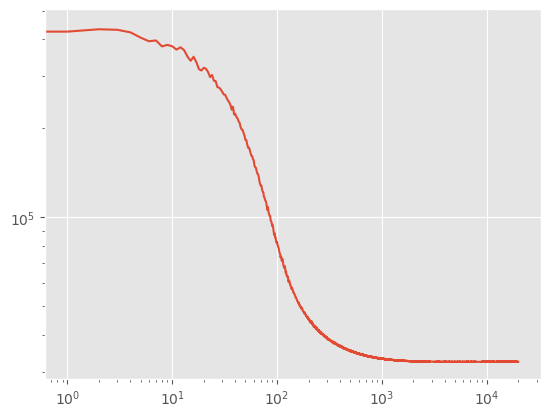

In [28]:
# Do a single run and examine the result
if (True):
    seed = 1954
    n_iter_optimizer = int(20e3)
    loss_saved, time_fvi = run_fvi(seed, n_iter_optimizer)
    print("loss", loss_saved[n_iter_optimizer - 1].data)


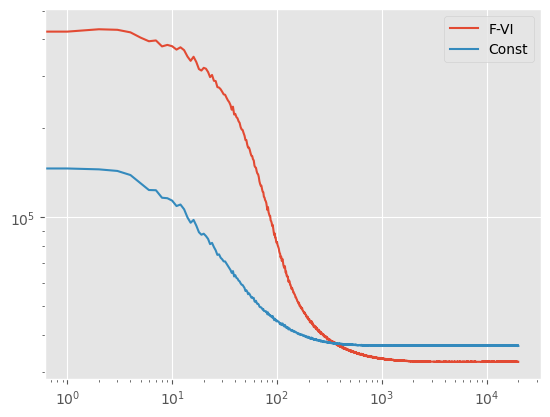

In [33]:
if True:
    plt.plot(loss_saved, label = "F-VI")
    plt.plot(loss_constant_saved, label = "Const")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend(loc = "best")

### Amortized VI

In [34]:
def run_avi(seed, inf_nn_width, n_iter_optimizer, print_output = False):
    torch.manual_seed(seed)
    model_av = MCElbo_AVI(inf_nn_width).to(device)
    
    optimizer = torch.optim.Adam(model_av.parameters(), lr = 1e-2)
    
    loss_av_saved = torch.empty((n_iter_optimizer,)) # np.empty(n_iter_optimizer)

    start_time = time.time()
    for i in range(n_iter_optimizer):
        loss_av = - model_av.compute_elbo(x)
        optimizer.zero_grad()
        loss_av.backward()
        optimizer.step()
        loss_av_saved[i] = loss_av.data
        if i % 5000 == 0 and print_output:
            print("loss", loss_av_saved[i])
    end_time = time.time()
    run_time = end_time - start_time
    return loss_av_saved, run_time

In [41]:
# function to run the experiments over multiple seeds
def run_experiment(seed, n_iter_optimizer, nn_widths, init_manifold = False, include_fvi = True):
    loss_all = torch.empty((n_iter_optimizer, 2 + nn_widths.size))
    saved_times = np.empty(2 + nn_widths.size)

    for i in range(nn_widths.size):
        loss_avi, time_avi = run_avi(seed, nn_widths[i], n_iter_optimizer)
        loss_all[:, i + 2] = loss_avi
        saved_times[i + 2] = time_avi
    
    if include_fvi:
        loss_fvi, time_fvi = run_fvi(seed, n_iter_optimizer, init_manifold)
        loss_all[:, 0] = loss_fvi
        saved_times[0] = time_fvi

        loss_const, time_const = run_fvi(seed, n_iter_optimizer, init_manifold, const_z=True)
        loss_all[:, 1] = loss_const
        saved_times[1] = time_const


    np.save("deliv/nonlin_loss_" + str(seed) + "_lock" + str(init_manifold), loss_all.detach().numpy())
    np.save("deliv/nonlin_time_" + str(seed) + "_lock" + str(init_manifold), saved_times)


In [45]:
n_iter_optimizer = int(20e3)
nn_widths = np.array([1, 2, 4, 8, 16, 24, 32])

init_seed = 1789
for i in range(10):
    seed = init_seed + i
    print("seed: ", seed)
    run_experiment(seed, n_iter_optimizer, nn_widths = nn_widths, init_manifold = False)


seed:  1789
seed:  1790
seed:  1791
seed:  1792
seed:  1793
seed:  1794
seed:  1795
seed:  1796
seed:  1797
seed:  1798


## Analyze results
Let's start by analyzing one realization of the experiment.

In [19]:
# read saved input
seed = 1797
init_manifold = False
loss_all = np.load("deliv/nonlin_loss_" + str(seed) + "_lock" + str(init_manifold) + ".npy")

loss_saved = loss_all[:, 0]


In [20]:
plt.style.use('seaborn-white')  # seaborn-v0_8-white

params = {'axes.labelsize': 18,'axes.titlesize':25, 'legend.fontsize': 20, 'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(params)

linewidth = 4

/tmp/ipykernel_3493473/3623882381.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')  # seaborn-v0_8-white


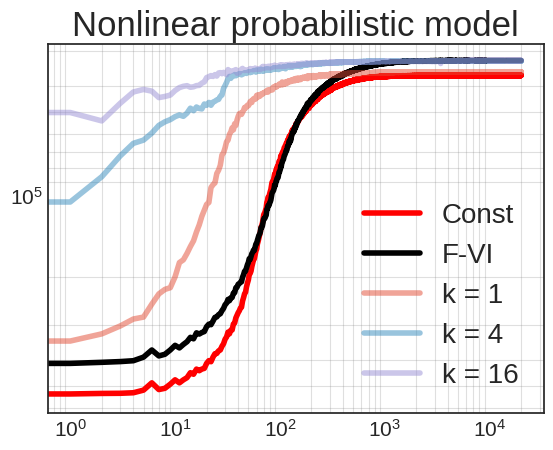

In [21]:

fig, ax =  plt.subplots()
plotted_widths = np.array([1, 4, 16])


ax.plot(loss_all[:, 1], label = 'Const', linewidth = linewidth, color = 'red')
ax.plot(loss_all[:, 0], label = 'F-VI', linewidth = linewidth, color = 'black')
nn_widths = np.array([1, 2, 4, 8, 16, 24, 32])
for i in range(nn_widths.size):
    if (nn_widths[i] in plotted_widths):
        ax.plot(loss_all[:, i + 2], label = "k = " + str(nn_widths[i]), alpha = 0.5,
                 linewidth = linewidth)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc = "best")
plt.gca().invert_yaxis()
plt.grid(which = 'minor', visible = 'true', c = 'grey', alpha = 0.25)
plt.title("Nonlinear probabilistic model")

plt.savefig("to_discuss/elbo_nonlin_normal_" + str(seed) + ".pdf", bbox_inches='tight')
plt.show()


In [22]:
def mean_window(loss, index_center, window):
    return np.mean(loss[(index_center - window):(index_center + window)])

def sd_window(loss, index_center, window):
    return np.std(loss[(index_center - window):(index_center + window)]) 


In [23]:
n_iter_optimizer = int(20000)

In [24]:
# Get asymptotic ELBO
window = 500
index_center = n_iter_optimizer - window
print("FVI: ", mean_window(loss_all[:, 0], index_center, window), " +/- ",
      sd_window(loss_all[:, 0], index_center, window))

print("Const: ", mean_window(loss_all[:, 1], index_center, window), " +/- ",
      sd_window(loss_all[:, 1], index_center, window))

for i in range(nn_widths.size):
  print("k = " + str(nn_widths[i]) + ": ", mean_window(loss_all[:, i + 2],
        index_center, window), " +/- ",
        sd_window(loss_all[:, i], index_center, window))


FVI:  32399.064  +/-  4.291028
Const:  36700.816  +/-  13.823418
k = 1:  35638.93  +/-  4.291028
k = 2:  32593.287  +/-  13.823418
k = 4:  32511.203  +/-  16.640911
k = 8:  32392.904  +/-  4.6295853
k = 16:  32386.713  +/-  4.288995
k = 24:  32385.643  +/-  4.221525
k = 32:  nan  +/-  8.967478


In [25]:
## Estimate of the convergence
# If oracle = False, compare subsequent windows.
def iter_convergence(loss, rel_tol = 0.01, init_iteration = 10, window = 10,
                     grid = 10, max_iteration = 20000, oracle = True, set_target = 0):
    iteration = init_iteration
    tol = 0
    diff = tol + 1
    while(diff > tol and iteration < max_iteration):
        iteration += grid
        if (oracle):
            target = set_target
        else:
            target = mean_window(loss, iteration - grid, window)

        tol = rel_tol * abs(target)
        diff = abs(mean_window(loss, iteration, window) - target)
        # print("diff:", diff)
        # print("tol:", tol)
    return iteration

# Q: should we report convergence to F-VI's solution or for each individual solution?
def iter_conv_wrapper(loss, loss_benchmark, rel_tol = 0.01, window = 10):
    return iter_convergence(loss, oracle = True, rel_tol = rel_tol,
                            set_target = mean_window(loss_benchmark, 19500, window))


In [26]:
print("FVI:", iter_conv_wrapper(loss_all[:, 0], loss_all[:, 0]))
for i in range(nn_widths.size):
  print("k = " + str(nn_widths[i]) + ": ",
        iter_conv_wrapper(loss_all[:, i + 2], loss_all[:, 0]))


FVI: 1440
k = 1:  20000
k = 2:  2140
k = 4:  570
k = 8:  910
k = 16:  640
k = 24:  330
k = 32:  15910


In [27]:
# Get results across multiple seeds
init_seed = 1789
num_seed = 10
init_manifold = False
n_algorithms = 9
num_tol = 3
rel_tol = np.array([0.5, 0.1, 0.01])

iter_to_conv = np.empty((num_seed, n_algorithms, num_tol))
Elbo_final = np.empty((num_seed, n_algorithms)) 

for i in range(num_seed):
    loss_all = np.load("deliv/nonlin_loss_" + str(init_seed + i) + "_lock" + str(init_manifold) + ".npy")

    for j in range(n_algorithms):
        Elbo_final[i, j] = mean_window(loss_all[:, j], n_iter_optimizer - window, window)
        for k in range(num_tol):
            # Use F-VI as the benchmark for the asymptotic ELBO
            iter_to_conv[i, j, k] = iter_conv_wrapper(loss_all[:, j], loss_all[:, 0], rel_tol[k])


In [28]:
print("mean iter:\n", np.median(iter_to_conv, axis = 0))
print("min iter:\n", np.min(iter_to_conv, axis = 0))
print("max iter:\n", np.max(iter_to_conv, axis = 0))
print(np.mean(Elbo_final, axis = 0))

mean iter:
 [[  180.   440.  1280.]
 [  165. 20000. 20000.]
 [   65. 20000. 20000.]
 [   60.   540. 20000.]
 [   40.   160.  1045.]
 [   20.    65.  1060.]
 [   20.    60.   555.]
 [   20.    65.   520.]
 [   25.    45.   250.]]
min iter:
 [[  170.   410.  1200.]
 [   90. 20000. 20000.]
 [   20.  2330. 20000.]
 [   20.    50.  2140.]
 [   20.    20.   230.]
 [   20.    20.   110.]
 [   20.    40.   170.]
 [   20.    30.   160.]
 [   20.    20.    20.]]
max iter:
 [[  250.   780.  2680.]
 [  310. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [ 9020.  9080. 20000.]
 [20000. 20000. 20000.]
 [17930. 17930. 17930.]
 [15910. 20000. 20000.]]
[3.23990402e+04 3.67008309e+04 3.96557605e+04 3.74381424e+04
 3.93635100e+04 3.25944828e+04 8.15405111e+13            nan
            nan]


In [29]:
# Get final Elbo
np.nanmin(Elbo_final, axis = 0)

array([32398.86132812, 36700.09765625, 35638.7265625 , 32593.28710938,
       32391.85546875, 32386.98632812, 32385.97851562, 32385.56835938,
       32385.38476562])